<a href="https://colab.research.google.com/github/luizcalaca/airbnb-cognitive/blob/master/desafio_cognitive_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset utilizado** - 21 January, 2020	Rio de Janeiro listings.csv	Summary - information and metrics for listings in Rio de Janeiro (good for visualisations) link: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2020-01-21/data/listings.csv.gz.

**Previsão do preço da estadia (feature ‘price’)**

**Análise Exploratória**

In [0]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import numpy
import gzip
import seaborn as sns

In [411]:
url = "http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2020-01-21/data/listings.csv.gz"

response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    ds = pd.read_csv(read_file)

print(ds.describe())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                 id  ...  reviews_per_month
count  3.475400e+04  ...       20348.000000
mean   1.993875e+07  ...           0.743797
std    1.284913e+07  ...           0.937498
min    1.787800e+04  ...           0.010000
25%    1.069316e+07  ...           0.120000
50%    1.589669e+07  ...           0.370000
75%    3.185959e+07  ...           1.000000
max    4.174458e+07  ...          11.540000

[8 rows x 45 columns]


**Retirar as colunas que não fazemm sentido ao problema da predição do valor**

In [0]:
ds = ds.drop(['id', 'listing_url','scrape_id', 'last_scraped', 'name','summary', 'space', 'description', 'neighborhood_overview', 'notes','transit','access','interaction','house_rules',
              'thumbnail_url','medium_url', 'picture_url','xl_picture_url','host_id','host_url','host_name', 'host_about','host_thumbnail_url','host_picture_url', 'host_verifications',
              'calendar_last_scraped','first_review','last_review','license','jurisdiction_names', 'cancellation_policy','zipcode'], axis=1)

**Verificação da dimensão dos dados (linhas, colunas)**

In [413]:
dim = ds.shape
print(dim)
print(ds.columns)

(34754, 74)
Index(['experiences_offered', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'market', 'smart_location', 'country_code', 'country',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights

**Verificação de nulos**

In [414]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34754 entries, 0 to 34753
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   experiences_offered                           34754 non-null  object 
 1   host_since                                    34749 non-null  object 
 2   host_location                                 34577 non-null  object 
 3   host_response_time                            22847 non-null  object 
 4   host_response_rate                            22847 non-null  object 
 5   host_acceptance_rate                          0 non-null      float64
 6   host_is_superhost                             34749 non-null  object 
 7   host_neighbourhood                            22505 non-null  object 
 8   host_listings_count                           34749 non-null  float64
 9   host_total_listings_count                     34749 non-null 

**Remoção de campos com alta porcentagem de nulos**

In [0]:
ds = ds.drop(['square_feet','weekly_price','monthly_price','host_acceptance_rate','neighbourhood_group_cleansed'], axis=1)

**Remoção do símbolo de valor monetório (dólar)**

In [416]:
ds.dtypes

experiences_offered                              object
host_since                                       object
host_location                                    object
host_response_time                               object
host_response_rate                               object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 69, dtype: object

In [0]:
def remove_simbolo_monetario(x):
    a =  x[1:] #remove apenas um caracter
    result = ""
    for i in a:
        if i.isdigit() is True:
            result = result + i
    return result #retorna os digíto, sem o símbolo

In [0]:
ds["price"] = pd.to_numeric(ds["price"].apply(remove_simbolo_monetario), errors= "ignore")
ds["extra_people"] = pd.to_numeric(ds["extra_people"].apply(remove_simbolo_monetario), errors= "ignore")
#ds["security_deposit"] = pd.to_numeric(ds["security_deposit"].apply(remove_simbolo_monetario), errors= "ignore")
#ds["cleaning_fee"] = pd.to_numeric(ds["extra_people"].apply(remove_simbolo_monetario), errors= "ignore")

In [419]:
ds.head()

,experiences_offered,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,none,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",within an hour,100%,t,Copacabana,2.0,2.0,t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,Rio de Janeiro,Rio de Janeiro,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.96592,-43.17896,t,Condominium,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",33200,$0.00,$378.00,2,6300,5,30,5,5,1125,1125,5.0,1125.0,6 weeks ago,t,1,7,37,312,246,26,93.0,10.0,10.0,10.0,10.0,10.0,9.0,f,t,f,f,f,1,1,0,0,2.12
1,none,2010-02-14,"Chicago, Illinois, United States",within an hour,100%,f,Ipanema,0.0,0.0,t,t,"Rio de Janeiro, RJ, Brazil",Ipanema,Ipanema,Rio de Janeiro,RJ,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.98467,-43.19611,t,Apartment,Entire home/apt,6,2.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",33600,"$2,098.00",$210.00,6,0,5,30,5,5,30,30,5.0,30.0,3 weeks ago,t,6,12,12,12,89,1,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,f,f,1,1,0,0,1.23
2,none,2010-04-03,"Rio de Janeiro, State of Rio de Janeiro, Brazil",within a day,86%,f,Copacabana,3.0,3.0,t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,Rio de Janeiro,Rio de Janeiro,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.97712,-43.19045,t,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",15900,"$1,000.00",$250.00,2,4500,7,60,7,7,60,60,7.0,60.0,3 days ago,t,13,16,16,21,237,15,94.0,9.0,10.0,9.0,10.0,10.0,9.0,f,f,f,t,t,3,3,0,0,2.02
3,none,2010-05-31,"Rio de Janeiro, Rio de Janeiro, Brazil",within an hour,100%,t,Ipanema,1.0,1.0,t,t,"Rio de Janeiro, RJ, Brazil",Ipanema,Ipanema,Rio de Janeiro,RJ,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.98302,-43.21427,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",27300,$0.00,$84.00,2,4200,2,1125,2,5,1125,1125,2.0,1125.0,2 weeks ago,t,0,12,40,130,277,39,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,t,f,f,f,1,1,0,0,2.39
4,none,2010-06-27,"San Carlos de Bariloche, Rio Negro, Argentina",within an hour,100%,f,Ipanema,1.0,1.0,t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Ipanema,Ipanema,Rio de Janeiro,Rio de Janeiro,Rio De Janeiro,"Rio de Janeiro, Brazil",BR,Brazil,-22.98816,-43.19359,t,Apartment,Entire home/apt,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",37800,"$1,049.00",$172.00,2,6300,2,89,2,2,89,89,2.0,89.0,4 months ago,t,2,13,24,108,174,35,94.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,f,t,t,1,1,0,0,2.29


**Transformamdo algumas colunas categóricaspara a representação numérica.**

In [0]:
ds['bed_type'] = ds.bed_type.astype('category')
ds['bed_type'].cat.categories
ds['bed_type'] = ds['bed_type'].cat.codes

In [0]:
ds['property_type'] = ds.property_type.astype('category')
ds['property_type'].cat.categories
ds['property_type'] = ds['property_type'].cat.codes

In [0]:
ds['room_type'] = ds.room_type.astype('category')
ds['room_type'].cat.categories
ds['room_type'] = ds['room_type'].cat.codes


**Verificação e remoção de outliers**

(34754, 69)

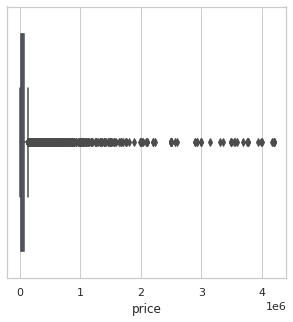

In [423]:
plt.figure(figsize = (5,5))
sns.boxplot(ds["price"])
ds.shape

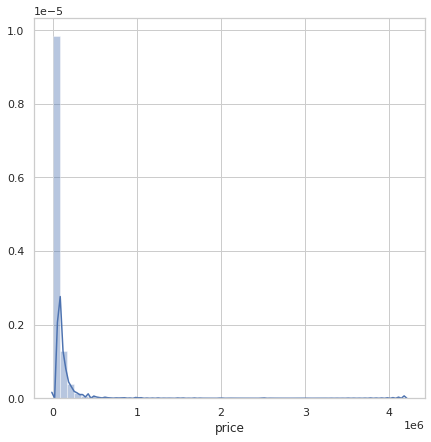

In [424]:
plt.figure(figsize = (7,7))
sns.set(style = "whitegrid")
f = sns.distplot(ds["price"])

In [0]:
q1 = ds["price"].quantile(0.25)
q3 = ds["price"].quantile(0.75)

IQR = q3 - q1
IF = q1 - (1.5 * IQR)
OF = q3 + (1.5 * IQR)

In [426]:
ds = ds[~((ds["price"] < IF) | (ds["price"] > OF))]
ds.shape

(31471, 69)

**Correlação**

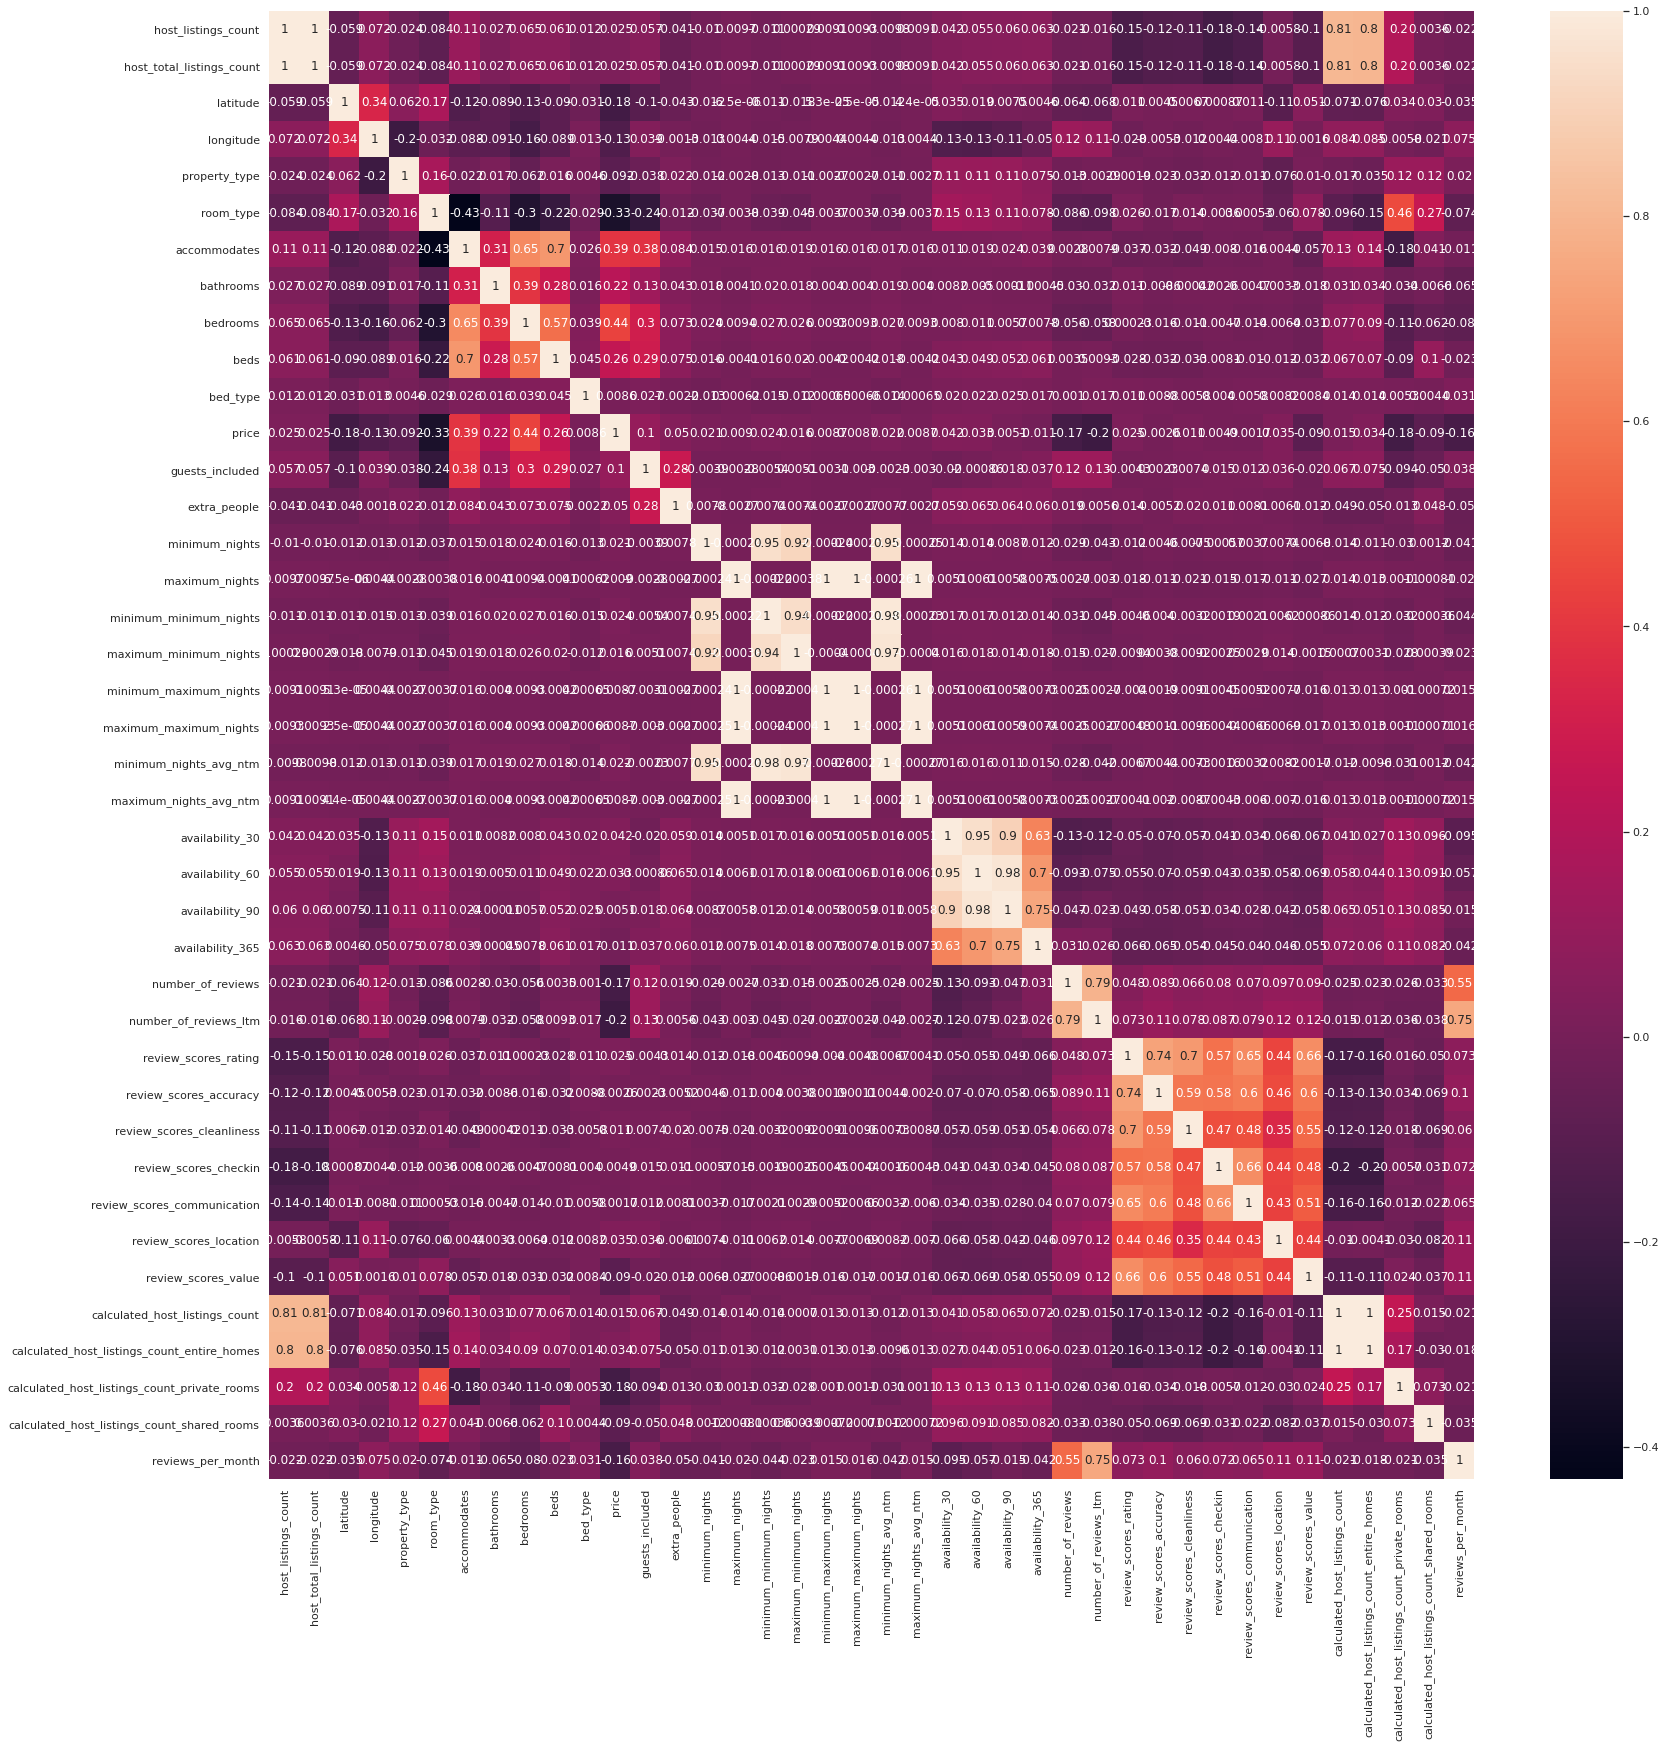

In [427]:
import seaborn as sns

plt.figure(figsize=(27,27))
sns.heatmap(ds.corr(), annot=True)

**Escolha de algumas variáveis a partir da correlação**

In [0]:
ds["accommodates"] = pd.to_numeric(ds["accommodates"], errors= "ignore")
ds["bathrooms"] = pd.to_numeric(ds["bathrooms"], errors= "ignore")
ds["bedrooms"] = pd.to_numeric(ds["bedrooms"], errors= "ignore")
ds["beds"] = pd.to_numeric(ds["beds"], errors= "ignore")
ds["room_type"] = pd.to_numeric(ds["room_type"], errors= "ignore")

# ds["review_scores_location"] = pd.to_numeric(ds["review_scores_location"], errors= "ignore")

In [0]:
#ds = ds.replace(numpy.nan, 0.0001)
#ds = ds.replace(0, 0.0001)
ds = ds.dropna()

**Colunas do treinamento e a label price procurada**

In [430]:
#x = ds.drop("price", axis = 1)

#columns = ['review_score_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']
x = ds[['accommodates', 'bathrooms','bedrooms','beds', 'room_type']]


y = ds["price"]
x.abs()

,accommodates,bathrooms,bedrooms,beds,room_type
0,5.0,1.0,2.0,2.0,0.0
1,6.0,2.0,2.0,4.0,0.0
2,2.0,1.0,1.0,2.0,0.0
3,3.0,1.0,1.0,2.0,0.0
4,2.0,1.5,1.0,1.0,0.0
...,...,...,...,...,...
34037,2.0,1.0,0.0,1.0,0.0
34077,4.0,2.0,2.0,2.0,0.0
34136,3.0,1.0,1.0,2.0,2.0
34203,4.0,1.0,1.0,4.0,0.0


**Separação dos conjunto de treinamento e teste**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# rkf.split(X)
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)
#random_state = 12883823
#rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
#x_train, x_test,y_train,y_test = rkf.split(x)

**Normalização dos dados**

In [0]:
#Normalizando train data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(x_train)
std_data = std.transform(x_train)

In [0]:
#Box-Cox
# from scipy import stats
# bx, lam = stats.boxcox(y_train)
# y_total = bx

Aplicação do **RandomForest**

In [434]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1500, verbose=1, criterion='mse')
rf.fit(std_data, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    5.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

**Predição**

In [0]:
#Standardization test data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(x_test)
std_test = std.transform(x_test)

In [436]:
pred = rf.predict(std_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    0.6s finished


In [0]:
#Box-Cox transformation for Test Response variable
bx, lam = stats.boxcox(y_test)
y_total_test = bx

In [0]:
def rmse_test(ytest, pred,xtest):
    err = ytest - pred
    mse = sum(err**2)/(xtest.shape[0]-xtest.shape[1]-1)
    rmse = numpy.sqrt(mse)
    print("RMSE será: ", rmse)

In [439]:
rmse_test(y_total_test,pred,x_test)

RMSE será:  32820.77732951238
